In [387]:
import import_ipynb
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils import shuffle
import xgboost as xgb
import matplotlib.pyplot as plt
import os
import mlflow

from sklearn.model_selection import GridSearchCV


from mlflow.models import infer_signature

# Import functions from other Jupyter notebook
import Utils.Time_Series_Classification_Helpers as ts_helpers
import Utils.Brain_Imaging_Classification_Helpers as bi_helpers
import Utils.Classification_Helpers as helpers

# Set Up MLFLow

In [388]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Import and Concatenate Data

In [389]:
subject_list = ["m292", "m294", "m298", "m299", "m300"]
label_list = [0, 1, 2, 3, 4]

## EEG/EMG Data

In [390]:
# Import dataframes that do not depend on folds
list_of_filenames = ["Topological_Summary_Statistics.csv", "Signature_Statistics.csv", "Advanced_Features.csv"]
#list_of_filenames = ["Statistical_Features.csv"]
time_series_feature_df = ts_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory="Time_Series")


list_of_filenames = ["Vectorization_Features.csv"]

fold_dependant_time_series_feature_df = ts_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory = "Time_Series")

list_of_filenames = ["Vectorization_Features_for_Final_Test.csv"]

fold_dependant_final_test_time_series_feature_df = ts_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory = "Time_Series")

## Brain Imaging

In [391]:
list_of_filenames = ["Topological_Summary_Statistics.csv", "Signature_Statistics.csv", "Advanced_Features.csv", "Direct_Coordinate_Features.csv"]
#list_of_filenames = ["Traditional_Features.csv"]

_, subject_feature_df = bi_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory="Brain_Imaging")

brain_imaging_feature_df = bi_helpers.cut_dataframe_to_same_length_as_TS(subject_feature_df, subject_list)


list_of_filenames = ["ATOL_Vectorization_Features.csv"]

_, subject_feature_df = bi_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory="Brain_Imaging")

fold_dependant_brain_imaging_feature_df = bi_helpers.cut_dataframe_to_same_length_as_TS(subject_feature_df, subject_list)


list_of_filenames = ["ATOL_Vectorization_Features_for_Final_Test.csv"]

_, subject_feature_df = bi_helpers.import_and_concatenate_datasets(subject_list, list_of_filenames, parent_directory="Brain_Imaging")

fold_dependant_final_test_brain_imaging_feature_df = bi_helpers.cut_dataframe_to_same_length_as_TS(subject_feature_df, subject_list)


## Merging

In [392]:
feature_df = helpers.merge_feature_dfs(time_series_feature_df, brain_imaging_feature_df)

fold_dependant_feature_df = helpers.merge_feature_dfs(fold_dependant_time_series_feature_df, fold_dependant_brain_imaging_feature_df)

## Preprocessing

In [393]:
feature_df.fillna(0, inplace=True)

## Save Features for Data Exploration

In [394]:
feature_df.to_csv("Features/All_Features.csv")

## Feature Engineering

In [395]:
print("There are "+str(len(feature_df.columns))+" features in the main dataframe.")

There are 2557 features in the main dataframe.


In [396]:
#for col in feature_df.columns:
#    print(col)

In [397]:
# For only using one feature 
#feature = "ATOL"
#columns_to_keep = feature_df.columns[feature_df.columns.str.contains(str(feature)+'|PD_Vectorization|Subject|Label')]
#feature_df = feature_df[columns_to_keep]

In [398]:
list_of_strings_in_column_names_to_remove = ["Nothing"]

feature_df = helpers.remove_columns_with_str(feature_df, list_of_strings_in_column_names_to_remove)

print("There are "+str(len(feature_df.columns))+" features in the main dataframe after filtering.")

There are 2557 features in the main dataframe after filtering.


# Cross Validation

In [364]:
# TODO This can be in the helper file as well
train_indices, validation_indices, test_indices = helpers.load_folds(subject_list, parent_directory = "Time_Series")

In [365]:
train_features_dfs_all_folds, train_labels_all_folds = helpers.filter_dataframe_with_indices(feature_df, train_indices, label_list)
validation_features_dfs_all_folds, validation_labels_all_folds = helpers.filter_dataframe_with_indices(feature_df, validation_indices, label_list)

In [366]:
# For fold-dependant ATOL coordinates
ATOL_train_features_dfs_all_folds, train_labels_all_folds = helpers.filter_fold_dependant_dataframe_with_indices(fold_dependant_feature_df, train_indices, label_list)
ATOL_validation_features_dfs_all_folds, validation_labels_all_folds = helpers.filter_fold_dependant_dataframe_with_indices(fold_dependant_feature_df, validation_indices, label_list)

In [367]:
# Combine ATOL vectorization features with all other features
train_features_dfs_all_folds  = helpers.combine_all_features(train_features_dfs_all_folds, ATOL_train_features_dfs_all_folds)
validation_features_dfs_all_folds  = helpers.combine_all_features(validation_features_dfs_all_folds, ATOL_validation_features_dfs_all_folds)

## Reformat Data

In [342]:
X_train, y_train, X_test, y_test = helpers.initialize_fold_dicts(train_features_dfs_all_folds, train_labels_all_folds, validation_features_dfs_all_folds, validation_labels_all_folds)

In [343]:
np.save('Features/All_Train_Features.npy', \
            np.array(X_train, dtype=object), allow_pickle=True)

np.save('Features/All_Train_Labels.npy', \
            np.array(y_train, dtype=object), allow_pickle=True)


np.save('Features/All_Test_Features.npy', \
            np.array(X_test, dtype=object), allow_pickle=True)

np.save('Features/All_Test_Labels.npy', \
            np.array(y_test, dtype=object), allow_pickle=True)


## MLFLow and GridSearch

Concatenate dataset for Gridsearch

In [344]:
# Concatenate train data of all folds such that the function GridSearchCV works on them
train_dfs = [X_train[0], X_train[1],  X_train[2],  X_train[3],  X_train[4]]

concatenated_X_train = pd.concat(train_dfs, ignore_index=True)

concatenated_y_train = y_train[0] + y_train[1] +  y_train[2] + y_train[3] + y_train[4]

### Random Forest

In [332]:
"""
# Define the parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create XGBClassifier
rf = RandomForestClassifier(**params)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=len(X_train[0]), verbose=2)

# Fit the grid search to the data
grid_search.fit(concatenated_X_train, concatenated_y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
"""

'\n# Define the parameter grid for GridSearch\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False]\n}\n\n# Create XGBClassifier\nrf = RandomForestClassifier(**params)\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=len(X_train[0]), verbose=2)\n\n# Fit the grid search to the data\ngrid_search.fit(concatenated_X_train, concatenated_y_train)\n\n# Get the best parameters and best score\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\nprint("Best Parameters:", best_params)\nprint("Best Score:", best_score)\n'

In [108]:
params = {"random_state": 1, "n_estimators": 1700, "min_samples_split": 6, "max_depth": 15}
#max_features
rf = RandomForestClassifier(**params)
all_accuracies = []
all_feature_importances = []

for fold in range(5):
    rf.fit(X_train[fold], y_train[fold])
    y_pred = rf.predict(X_test[fold])
    accuracy = accuracy_score(y_pred, y_test[fold])
    all_accuracies.append(accuracy)
    print("Accuracy for fold", fold + 1, ":", accuracy)
    
    feature_importances = rf.feature_importances_
    all_feature_importances.append(feature_importances)

average_accuracy = np.mean(all_accuracies)
print("Average Accuracy:", average_accuracy)

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


KeyboardInterrupt: 

In [ ]:
average_feature_importance = np.mean(all_feature_importances, axis=0)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_feature_importance)), average_feature_importance, color='b', align='center')
#plt.xticks(range(len(average_feature_importance)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance Over All Folds')
plt.show()

In [ ]:
# Get indices of top 20 features with maximal importance
top_20_indices = np.argsort(average_feature_importance)[::-1][:20]

# Plotting feature importances for top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_20_indices)), average_feature_importance[top_20_indices], color='b', align='center')
plt.xticks(range(len(top_20_indices)), X_train[fold].columns[top_20_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance of Top 20 Features Over All Folds')
# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.savefig('Top_feature_importances.png')  # Save as PNG
plt.show()

In [ ]:
mlflow_params = params
features = X_train[0].columns
mlflow_params["features"] = features

In [ ]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(mlflow_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", average_accuracy)
    mlflow.log_metric("minimal accuracy",  np.min(all_accuracies))
    mlflow.log_metric("maximal accuracy",  np.max(all_accuracies))

    # Log data
    mlflow.log_artifact("Features/All_Train_Features.npy")
    mlflow.log_artifact("Features/All_Train_Labels.npy")
    mlflow.log_artifact("Features/All_Test_Features.npy")
    mlflow.log_artifact("Features/All_Test_Labels.npy")
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Random Forest - Both Modalities")
    mlflow.set_tag('mlflow.runName', 'Random Forest - Both Modalities')

### XGBoost

In [298]:
"""
# Define the parameter grid
param_grid = {
    "learning_rate": [0.1, 0.18, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 2, 3],
    "subsample": [0.5]
}

# Create XGBClassifier
xb = xgb.XGBClassifier(seed=1)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xb, param_grid=param_grid, cv=len(X_train[0]), verbose=2)

# Fit the grid search to the data
grid_search.fit(concatenated_X_train, concatenated_y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
"""

'\n# Define the parameter grid\nparam_grid = {\n    "learning_rate": [0.1, 0.18, 0.2],\n    "n_estimators": [100, 200, 300],\n    "max_depth": [3, 4, 5],\n    "min_child_weight": [1, 2, 3],\n    "subsample": [0.5]\n}\n\n# Create XGBClassifier\nxb = xgb.XGBClassifier(seed=1)\n\n# Perform GridSearchCV\ngrid_search = GridSearchCV(estimator=xb, param_grid=param_grid, cv=len(X_train[0]), verbose=2)\n\n# Fit the grid search to the data\ngrid_search.fit(concatenated_X_train, concatenated_y_train)\n\n# Get the best parameters and best score\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\nprint("Best Parameters:", best_params)\nprint("Best Score:", best_score)\n'

In [33]:
#params = {"seed": 1, "learning_rate": 0.19, "n_estimators": 290, "max_depth": 4, "min_child_weight": 0, "max_delta_step": 1, "subsample":0.5}

params = {"seed": 1, "learning_rate": 0.19, "n_estimators": 240, "max_depth": 4, "min_child_weight": 0, "max_delta_step": 1, "subsample":0.5}

#params = best_params
xb = xgb.XGBClassifier(**params)
all_accuracies = []
all_feature_importances = []

for fold in range(len(X_train)):
    # Remove duplicate columns
    X_train[fold] = helpers.keep_first_duplicate_columns(X_train[fold])

    xb.fit(X_train[fold], y_train[fold])

    X_test[fold] = X_test[fold].loc[:, ~X_test[fold].columns.duplicated()]

    y_pred = xb.predict(X_test[fold])
    accuracy = accuracy_score(y_pred, y_test[fold])
    all_accuracies.append(accuracy)
    print("Accuracy for fold", accuracy)

    # Get feature importances for the current fold
    feature_importances = xb.feature_importances_
    all_feature_importances.append(feature_importances)

average_accuracy = np.mean(all_accuracies)
print("Mean Accuracy:", average_accuracy)

Accuracy for fold 0.98
Accuracy for fold 0.9833333333333333
Accuracy for fold 0.9866666666666667
Accuracy for fold 0.9766666666666667
Accuracy for fold 0.9636363636363636
Mean Accuracy: 0.9780606060606061


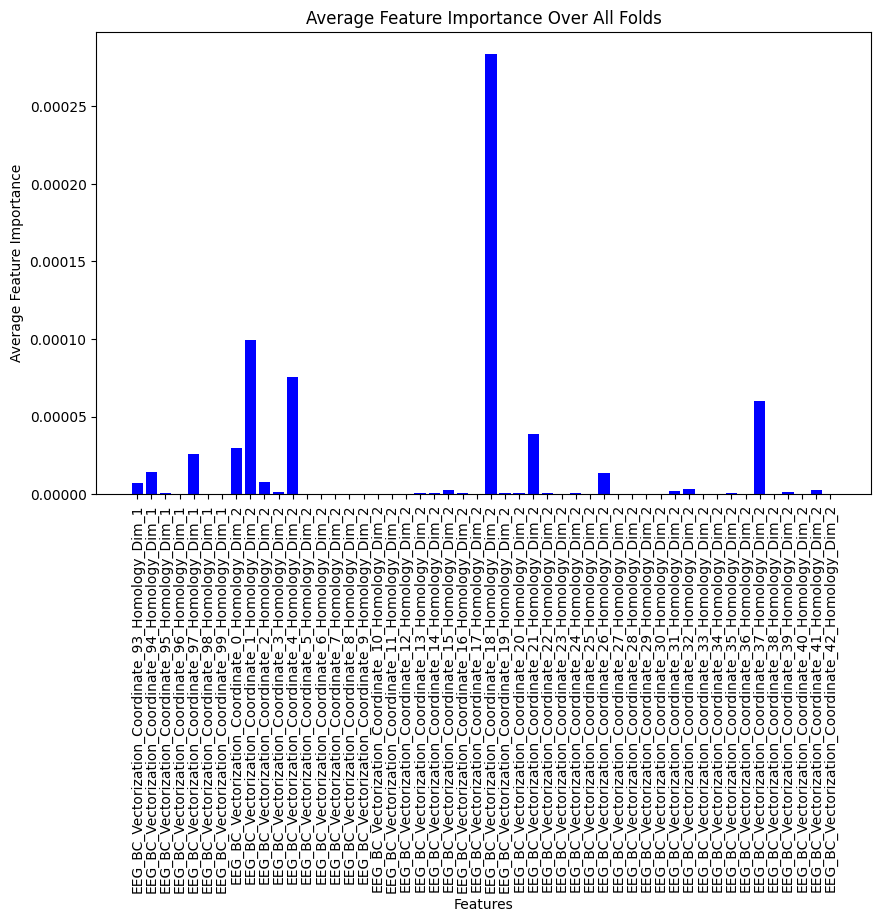

In [112]:
range_begin = 550
range_end = 600

average_feature_importance = np.mean(all_feature_importances, axis=0)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_feature_importance[range_begin:range_end])), average_feature_importance[range_begin:range_end], color='b', align='center')
plt.xticks(range(len(average_feature_importance[range_begin:range_end])), X_train[fold].columns[range_begin:range_end], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance Over All Folds')
plt.savefig('All_feature_importances.png')  # Save as PNG
plt.show()
# Using all features - leaving out one feature

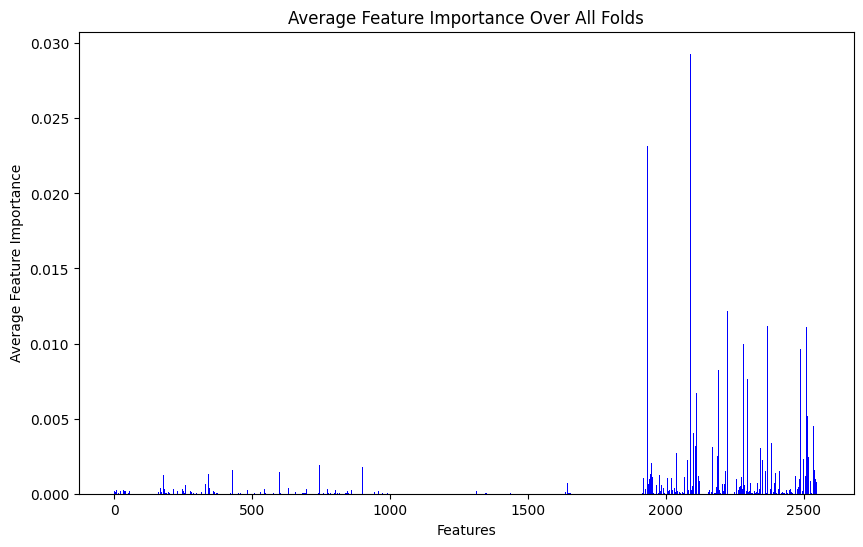

In [113]:
average_feature_importance = np.mean(all_feature_importances, axis=0)

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(average_feature_importance)), average_feature_importance, color='b', align='center')
#plt.xticks(range(len(average_feature_importance)), X_train[fold].columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance Over All Folds')
plt.savefig('All_feature_importances.png')  # Save as PNG
plt.show()
# Using all features - leaving out one feature

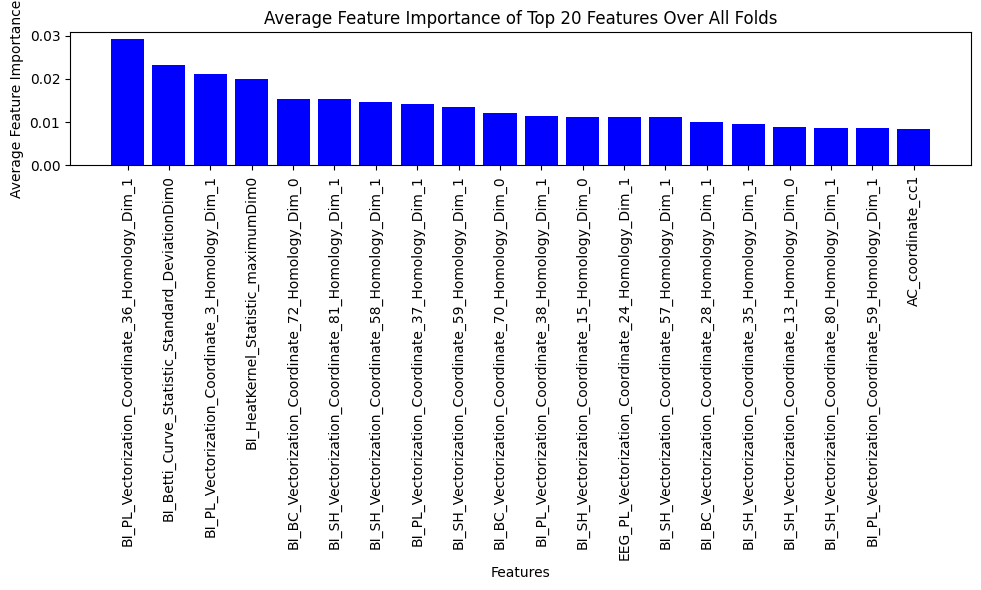

In [114]:
# Get indices of top 20 features with maximal importance
top_20_indices = np.argsort(average_feature_importance)[::-1][:20]

# Plotting feature importances for top 20 features
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_20_indices)), average_feature_importance[top_20_indices], color='b', align='center')
plt.xticks(range(len(top_20_indices)), X_train[fold].columns[top_20_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Average Feature Importance')
plt.title('Average Feature Importance of Top 20 Features Over All Folds')
# Adjust subplot parameters to give specified padding
plt.tight_layout()
plt.savefig('Top_feature_importances.png')  # Save as PNG
plt.show()

In [ ]:
mlflow_params = params
features = X_train[0].columns
mlflow_params["features"] = features

In [ ]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(mlflow_params)

    # Log the loss metric
    mlflow.log_metric("accuracy", average_accuracy)
    mlflow.log_metric("minimal accuracy",  np.min(all_accuracies))
    mlflow.log_metric("maximal accuracy",  np.max(all_accuracies))

    # Log data
    mlflow.log_artifact("Features/All_Train_Features.npy")
    mlflow.log_artifact("Features/All_Train_Labels.npy")
    mlflow.log_artifact("Features/All_Test_Features.npy")
    mlflow.log_artifact("Features/All_Test_Labels.npy")
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "XGBoost - Both Modalities")
    mlflow.set_tag('mlflow.runName', 'XGBoost - Both Modalities')

# Final Test Set

In [400]:
def concatenate_final_training_and_test_indices(train_indices, validation_indices, subject_list, label_list):
    """
    The new training data consists of the previous training plus the previous validation data
    """

    final_train_indices = {}

    for subject in subject_list:

        # Initialize
        final_train_indices[subject] = {}
        
        train_indices_for_subject = train_indices[subject]
        validation_indices_for_subject = validation_indices[subject]

        for label in label_list:
            # It does not matter which fold we choose, so simply choose fold 0
            train_indices_to_combine = train_indices_for_subject["Label_"+str(label)]["Fold_0"]
            validation_indices_to_combine = validation_indices_for_subject["Label_"+str(label)]["Fold_0"]
            final_train_indices[subject]["Label_"+str(label)] = np.concatenate((train_indices_to_combine, validation_indices_to_combine))


    return final_train_indices
      
    

In [401]:
# Get final training indicesfold_dependant_feature_df = helpers.merge_feature_dfs(fold_dependant_final_test_time_series_feature_df, fold_dependant_final_test_brain_imaging_feature_df)

final_train_indices = concatenate_final_training_and_test_indices(train_indices, \
                            validation_indices, subject_list, label_list)

In [402]:
fold_dependant_final_test_feature_df = helpers.merge_feature_dfs(fold_dependant_final_test_time_series_feature_df, fold_dependant_final_test_brain_imaging_feature_df)

# Concatenate ATOL features with all other features
fold_dependant_final_test_feature_df.pop("Label")
fold_dependant_final_test_feature_df.pop("Fold")
fold_dependant_final_test_feature_df.pop("Subject")
fold_dependant_final_test_feature_df.pop("Subject_BI")

feature_df = pd.concat([feature_df, fold_dependant_final_test_feature_df], axis=1)


In [403]:
# Get final test sets
X_train_final, y_train_final, X_test_final, y_test_final = helpers.create_final_input_data_dicts(feature_df,          
                                        final_train_indices, test_indices, label_list)

## Random Forest

In [153]:
final_accuracies = [] 

for seed in range(10):

    params = {"random_state": seed, "n_estimators": 1700, "min_samples_split": 6, "max_depth": 15}

    rf = RandomForestClassifier(**params)

    rf.fit(X_train_final, y_train_final)
    y_pred = rf.predict(X_test_final)
    accuracy = accuracy_score(y_pred, y_test_final)
    print("Accuracy:", accuracy)

    final_accuracies.append(accuracy)


print("Mean accuracy " + str(np.mean(final_accuracies)) + ", with standard deviation "+str(np.std(final_accuracies)) + ".")

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy: 0.8106666666666666



KeyboardInterrupt



## XGBoost

In [ ]:
final_accuracies = [] 

for seed in range(10):

    params = {"seed": seed, "learning_rate": 0.19, "n_estimators": 250, "max_depth": 4, "min_child_weight": 0, "max_delta_step": 1, "subsample":0.5}

    xb = xgb.XGBClassifier(**params)

    xb.fit(X_train_final, y_train_final)
    y_pred = xb.predict(X_test_final)
    accuracy = accuracy_score(y_pred, y_test_final)
    print("Accuracy:", accuracy)

    final_accuracies.append(accuracy)


print("Mean accuracy " + str(np.mean(final_accuracies)) + ", with standard deviation "+str(np.std(final_accuracies)) + ".")

Accuracy: 0.9973333333333333
Accuracy: 0.9973333333333333
Accuracy: 0.9973333333333333


# Decision Tree Feature Importance

In [155]:
feature_importances = xb.feature_importances_

mask = feature_df.columns.str.contains('AC_coordinate')
# Use numpy to get the indices where the mask is True
indices = np.where(mask)[0]